<a href="https://colab.research.google.com/github/Ibtihaj-Khan/CIFAR10/blob/main/Practice_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [62]:
import torch
from torch import nn
from matplotlib import pyplot as plt
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import requests
from timeit import default_timer as timer
from tqdm.auto import tqdm

#Using accuracy function from this source (Thanks)
request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import accuracy_fn

In [63]:
#Initialize device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

In [64]:
#Get the Sample Data and split into train and test datasets to pass into the data loaders

train_data = datasets.CIFAR10(root='data',
                              train=True,
                              transform=ToTensor(),
                              download=True)

test_data = datasets.CIFAR10(root='data',
                              train=False,
                              transform=ToTensor(),
                              download=True)

Files already downloaded and verified
Files already downloaded and verified


In [65]:
#Convert our train and test data into data loaders. Shuffle training data incase theres a bunch of related images next to each other. This improves training
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=32,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=32)

In [66]:
#It appears that our data is returned as a tuple X - the image, y - the label (name of the item).
sample_image, sample_label = train_data[2] # <-Can modify this number to see diff samples, or even change this to test_data

#Let's take it apart and create a list of classes for future reference.
class_names = train_data.classes

(-0.5, 31.5, 31.5, -0.5)

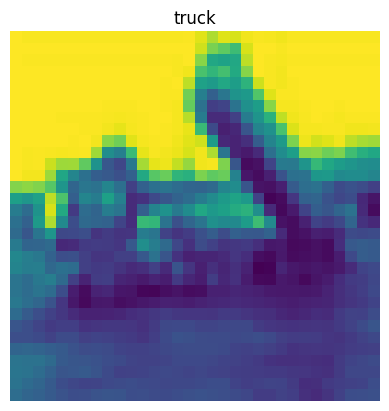

In [67]:
#Visualize our data by plotting. This is removing the color channels.

plt.imshow(sample_image[0])
plt.title(class_names[sample_label])
plt.axis(False)

In [68]:
sample_image.shape

torch.Size([3, 32, 32])

It looks like we are dealing with a multi-class image classification problem in this dataset. Let's replicate the TinyVGG convolutional NN as our model: https://poloclub.github.io/cnn-explainer/; as it seems to do a pretty good job.

It appears to be comprised of a Conv2d -> Relu -> Conv2d -> Relu -> MaxPool layers repeated twice, leading to an output layer.

In [69]:
class TinyVGG(nn.Module):
  def __init__(self, in_features, hidden_units, out_features):
    super().__init__()

    self.block1=nn.Sequential(
        nn.Conv2d(in_channels=in_features,
                  out_channels=hidden_units,
                  kernel_size=3,
                  padding=1,
                  stride=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  padding=1,
                  stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.block2=nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  padding=1,
                  stride=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  padding=1,
                  stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.output_layer=nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*8*8, #we determine this below when we run sample image in the below block
                  out_features=out_features)
    )

  def forward(self, x):
    #print(x.shape)
    x=self.block1(x)
    #print(x.shape) #print to determine how the shape is changing as it passes through - to determine output layer in features
    x=self.block2(x)
    #print(x.shape)
    x=self.output_layer(x)
    #print(x.shape)
    return x

When we run the line below the first time, before adding 8*8 multiple to linear in features, we find out that the size is going down from

torch.Size([3, 32, 32]) ->
torch.Size([10, 16, 16]) ->
torch.Size([10, 8, 8])

This tells us we need to flatten against the 1st dim and also multiply the in units by hiddenx8x8. The reason we use the 1st dim is because we add batch as a dim. [batch, color channels, X, Y]

This gives us a final output tensor of torch.Size([32, 100]) which matches expected classes.

In [70]:
#Instantiate the model, send it to the device and figure out linear layer input size
IN_FEATURES = 3 #index 0 of the shape, we have 3 color channels
HIDDEN_UNITS = 10
OUT_FEATURES = len(class_names) #Output features is the total class list

model_0 = TinyVGG(in_features=IN_FEATURES,
                  hidden_units=HIDDEN_UNITS,
                  out_features=OUT_FEATURES).to(device)

#Do a dummy pass to make sure our model is giving us preds
sample_logit = model_0(sample_image.unsqueeze(0).to(device))
sample_prediction = torch.softmax(sample_logit,dim=0).argmax(dim=1)

#Our model is pretty wrong right now, every time we run it, it seems to guess wrong. Recall above that we should be thinking it is a telephone.
class_names[sample_prediction]

'airplane'

# For cleanliness in our training and test loops, we will functionalize train and test steps.

In [71]:
def train_step(model, data_loader, loss_fn, optimizer, accuracy_fn):
  train_loss, train_acc = 0, 0

  #Send model to device, put it in training mode
  model.to(device)
  model.train()

  for batch, (X, y) in enumerate(data_loader):
    #Send data to the target device
    X, y = X.to(device), y.to(device)

    #Do the forward pass
    train_logit = model(X)
    train_prediction = torch.softmax(train_logit, dim=0).argmax(dim=1)

    #Calculate the loss/acc
    loss = loss_fn(train_logit, y)
    train_loss += loss
    train_acc += accuracy_fn(y_true=y,
                             y_pred=train_prediction)

    #Zero gradient
    optimizer.zero_grad()

    #loss backward
    loss.backward()

    #Optimizer step
    optimizer.step()

  train_loss /= len(data_loader)
  train_acc /= len(data_loader)

  print(f"Training loss: {train_loss} | Training accuracy: {train_acc}%.")

In [72]:
def test_step(model, data_loader, loss_fn, accuracy_fn):
  test_loss, test_acc = 0, 0

  #Send model to target device, put model in evaluation mode.
  model.to(device)
  model.eval()

  #Use inference mode context manager to improve performance when making predictions.
  with torch.inference_mode():
    for batch, (X, y) in enumerate(data_loader):
      #Send data to target device
      X, y = X.to(device), y.to(device)

      #Forward pass
      test_logit = model(X)
      test_prediction = torch.softmax(test_logit, dim=0).argmax(dim=1)

      #Calculate loss and accuracy
      loss = loss_fn(test_logit, y)
      test_loss += loss

      test_acc += accuracy_fn(y_true=y,
                              y_pred=test_prediction)

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)

  print(f"Testing loss: {test_loss} | Testing accuracy: {test_acc}%.")


# Time for our training loops

We will select the loss function of CrossEntropyLoss since that is standard for multi class problems.

Using SGD for our optimizer.

In [73]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.03)

In [74]:
#Longer training may result in better results
epochs = 10

#Lets get the total time of training
start_time = timer()

for epoch in tqdm(range(epochs)):
  print(f"\nEpoch: {epoch}:")

  #Based functionalized steps
  train_step(model=model_0,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy_fn)

  test_step(model=model_0,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn)

end_time = timer()

print(f"Total Training Time: {end_time-start_time:.2f}.")

  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 0:
Training loss: 2.1073391437530518 | Training accuracy: 24.592130518234164%.
Testing loss: 1.842775583267212 | Testing accuracy: 34.46485623003195%.

Epoch: 1:
Training loss: 1.7573131322860718 | Training accuracy: 36.534309021113245%.
Testing loss: 1.6416616439819336 | Testing accuracy: 41.74321086261981%.

Epoch: 2:
Training loss: 1.5276607275009155 | Training accuracy: 43.5180742162508%.
Testing loss: 1.599328637123108 | Testing accuracy: 45.027955271565496%.

Epoch: 3:
Training loss: 1.3881731033325195 | Training accuracy: 47.5587811900192%.
Testing loss: 1.3400462865829468 | Testing accuracy: 48.82188498402556%.

Epoch: 4:
Training loss: 1.2818725109100342 | Training accuracy: 50.24992002559181%.
Testing loss: 1.22556734085083 | Testing accuracy: 50.888578274760384%.

Epoch: 5:
Training loss: 1.2020387649536133 | Training accuracy: 52.50919705694178%.
Testing loss: 1.2457225322723389 | Testing accuracy: 51.79712460063898%.

Epoch: 6:
Training loss: 1.1448414325714111 | T

The model seems to be training, but quite frankly the accuracy is not the best... when ran (10 total epochs), we reach roughly 55% accuracy.

May be a different model would provide a better fit. Lets plot the confusion matrix to see where the model is messing up.

In [75]:
!pip install torchmetrics -q

import torchmetrics, mlxtend

In [76]:
#Make predictions on the test dataset
y_preds = []

model_0.eval()

with torch.inference_mode():
  for X, y in tqdm(test_dataloader):
    X, y = X.to(device), y.to(device)
    y_logit = model_0(X)

    y_prediction = torch.softmax(y_logit, dim=0).argmax(dim=1)

    y_preds.append(y_prediction.cpu())

y_pred_tensor = torch.cat(y_preds)

  0%|          | 0/313 [00:00<?, ?it/s]

In [77]:
y_pred_tensor[:5]

tensor([3, 8, 0, 0, 6])

Creating the confusion matrix.

In [78]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
import numpy as np

In [79]:
confmat = ConfusionMatrix(num_classes=len(class_names),
                          task='multiclass')

In [80]:
confmat_tensor = confmat(y_pred_tensor, torch.tensor(test_data.targets))
confmat_tensor

tensor([[634,  11, 107,  39,  32,  19,   8,  19, 100,  31],
        [ 72, 537,  14,  39,   9,   8,  33,  21,  73, 194],
        [ 63,   6, 508, 111, 122,  72,  69,  32,  12,   5],
        [ 21,   8,  81, 511,  79, 160,  82,  34,  12,  12],
        [ 23,   3, 145, 103, 538,  43,  61,  68,   9,   7],
        [ 12,   0,  84, 249,  70, 464,  36,  73,   6,   6],
        [  8,   3,  82, 149,  86,  23, 629,   8,  10,   2],
        [ 16,   1,  56, 107, 124, 106,  14, 559,   2,  15],
        [189,  45,  35,  37,  18,  14,  14,  12, 596,  40],
        [ 66, 106,  12,  48,  22,  20,  22,  34,  58, 612]])

Visualize the confusion matrix

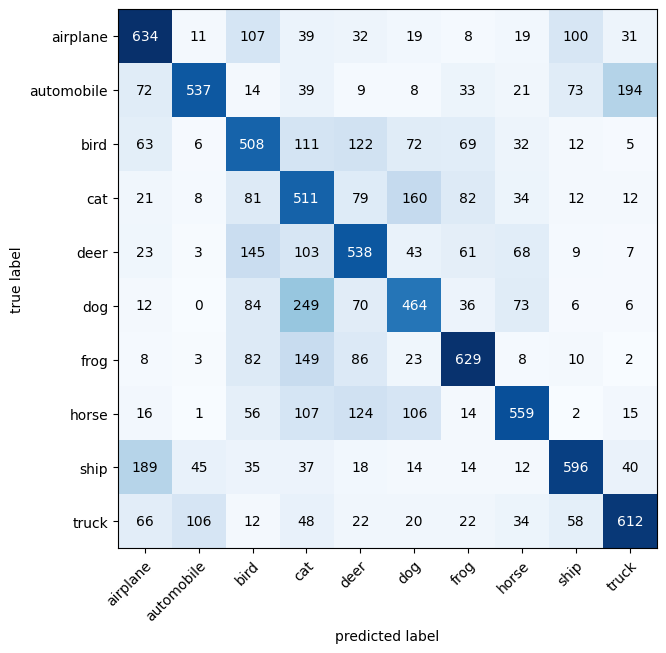

In [81]:
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7)
);

Based on the above, for the most part, it does a decent job of making predictions. Common areas it is confusing is dog/cat - deer/horse - dog/horse - these are all atleast four legged animals with tails so it can sorta make sense. Confusing automobile with truck is potentially a problem with our data not being specific enough, because all trucks are automobiles.

Some of the weird ones are where it is confusing ship with airplane, and bied wth other animals. I would say overall the confusion is beyond that of a normal human, and the model is simply not good enough. Time to improve the model.